In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
from torch.nn.functional import (
    avg_pool2d,
    dropout,
    dropout2d,
    interpolate,
    max_pool2d,
    relu,
    sigmoid,
    tanh,
)
from torch.nn import (
    Module, Parameter, init,
    Conv2d, ConvTranspose2d, Linear, LSTM, GRU,
    BatchNorm1d, BatchNorm2d,
    PReLU
)
from cplxmodule.nn import CplxMaxPool2d


In [2]:
def apply_complex(fr, fi, input, dtype=torch.complex64):
    return (fr(input.real)-fi(input.imag)).type(dtype) \
        + 1j*(fr(input.imag)+fi(input.real)).type(dtype)

# Creates a complex noise vector of dimension (n_samples, z_dim). Every value is complex.
def get_noise(n_samples, z_dim, device='cpu'):
    real = torch.randn(n_samples, z_dim, dtype=torch.float32, device=device)
    imag = torch.randn(n_samples, z_dim, dtype=torch.float32, device=device)
    return torch.complex(real, imag)
    
def complex_relu(inp):
    return relu(inp.real).type(torch.complex64) + 1j * relu(inp.imag).type(torch.complex64)


def complex_sigmoid(inp):
    return sigmoid(inp.real).type(torch.complex64) + 1j * sigmoid(inp.imag).type(torch.complex64)


def complex_tanh(inp):
    return tanh(inp.real).type(torch.complex64) + 1j * tanh(inp.imag).type(
        torch.complex64
    )

class ComplexReLU(Module):
    @staticmethod
    def forward(inp):
        return complex_relu(inp)

class ComplexTanh(Module):
    @staticmethod
    def forward(inp):
        return complex_tanh(inp)


class ComplexSigmoid(Module):
    @staticmethod
    def forward(inp):
        return complex_sigmoid(inp)
      

class ComplexPReLU(Module):
    def __init__(self):
        super().__init__()
        self.r_prelu = PReLU()        
        self.i_prelu = PReLU()

    @staticmethod
    def forward(self, inp):
        return self.r_prelu(inp.real) + 1j*self.i_prelu(inp.imag)

class ComplexLinear(Module):
    def __init__(self, in_features, out_features):
        super().__init__()
        self.fc_r = Linear(in_features, out_features) # Linear layer for the real part
        self.fc_i = Linear(in_features, out_features) # Linear Layer for the imaginary part

    def forward(self, inp):
        return apply_complex(self.fc_r, self.fc_i, inp)


class TwoChannelsToComplex(nn.Module):
    def __init__(self):
        super(TwoChannelsToComplex, self).__init__()

    def forward(self, x):
        real, imag = torch.chunk(x, 2, dim=1)
        complex_tensor = torch.complex(real.squeeze(1), imag.squeeze(1))
        return complex_tensor
class ComplexToTwoChannels(nn.Module):
    def __init__(self):
        super(ComplexToTwoChannels, self).__init__()

    def forward(self, x):
        real = x.real.unsqueeze(1)
        imag = x.imag.unsqueeze(1)
        two_channel_tensor = torch.cat((real, imag), dim=1)
        return two_channel_tensor

class InverseFourierTransform2D(nn.Module):
    def __init__(self, norm='ortho'):
        super(InverseFourierTransform2D, self).__init__()
        self.norm = norm

    def forward(self, x):
        return torch.fft.ifft2(x, norm=self.norm)


# class FourierConv2d(nn.Module):
#     def __init__(self, in_channels, out_channels, kernel_size):
#         super(FourierConv2d, self).__init__()
#         self.in_channels = in_channels
#         self.out_channels = out_channels
#         self.kernel_size = kernel_size

#         # Initialize complex-valued filters
#         self.real_filter = nn.Parameter(torch.empty(1,out_channels, in_channels, kernel_size, kernel_size))
#         self.imag_filter = nn.Parameter(torch.empty(1,out_channels, in_channels, kernel_size, kernel_size))
#         self.reset_parameters()
    
#     def reset_parameters(self):
#         # Initialize filter weights
#         nn.init.kaiming_uniform_(self.real_filter, a=0, mode='fan_in', nonlinearity='relu')
#         nn.init.kaiming_uniform_(self.imag_filter, a=0, mode='fan_in', nonlinearity='relu')

#     def forward(self, x):
#         # Combine real and imaginary parts to create complex-valued filters
#         print(x.shape)
#         print("real_filter shape_", self.real_filter.shape)
#         complex_filter = torch.complex(self.real_filter, self.imag_filter)
#         print("Filter shape: ",complex_filter.shape)

#         # Perform complex elementwise multiplication
#         output = x * complex_filter

#         return output
    

    

class ComplexMaxPool2d(nn.Module):
    def __init__(self, kernel_size, stride=None, padding=0, dilation=1, return_indices=False, ceil_mode=False):
        super(ComplexMaxPool2d, self).__init__()
        self.kernel_size = kernel_size
        self.stride = stride or kernel_size
        self.padding = padding
        self.dilation = dilation
        self.return_indices = return_indices
        self.ceil_mode = ceil_mode

    def forward(self, x):
        # Compute the absolute values of the complex numbers
        abs_values = torch.abs(x)

        # Apply max pooling on the absolute values
        _, indices = nn.functional.max_pool2d(
            abs_values,
            kernel_size=self.kernel_size,
            stride=self.stride,
            padding=self.padding,
            dilation=self.dilation,
            ceil_mode=self.ceil_mode,
            return_indices=True
        )

        # Use the indices to select the corresponding complex numbers
        output = torch.gather(x, dim=2, index=indices.unsqueeze(2).expand(-1, -1, x.size(2), -1))
        output = torch.gather(output, dim=3, index=indices.unsqueeze(3).expand(-1, -1, -1, x.size(3)))

        if self.return_indices:
            return output, indices
        else:
            return output.squeeze()

#  Download the Fashion MNIST dataset

In [3]:


transform = transforms.Compose([transforms.ToTensor()])
train_data = datasets.FashionMNIST(root='data', train=True, download=True, transform=transform)
test_data = datasets.FashionMNIST(root='data', train=False, download=True, transform=transform)

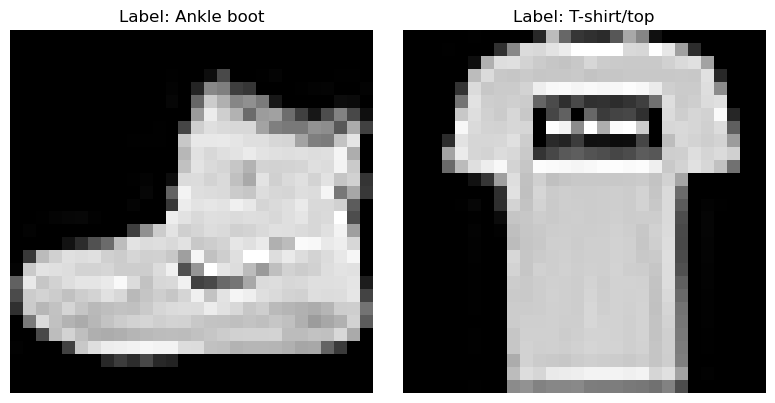

In [4]:

fig, ax = plt.subplots(1, 2, figsize=(8, 4))
for i in range(2):
    image, label = train_data[i]
    ax[i].imshow(image.squeeze(), cmap='gray')
    ax[i].set_title(f"Label: {train_data.classes[label]}")
    ax[i].axis('off')
plt.tight_layout()
plt.show()


# Perform the Fourier Transform on all data

In [5]:

def fft_transform(data):
    fft_data = []
    for img, _ in data:
        fft = np.fft.fft2(img.numpy().squeeze())
        fft_data.append(fft)
    return np.array(fft_data)

train_fft = fft_transform(train_data)
test_fft = fft_transform(test_data)





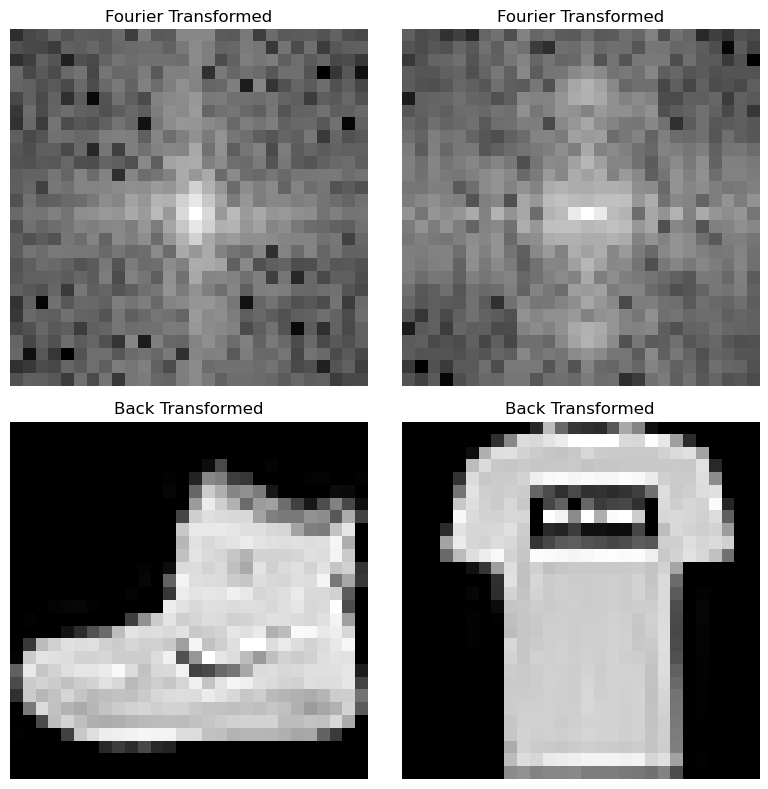

In [6]:
# 4. Plot Fourier transformed and back-transformed examples
fig, ax = plt.subplots(2, 2, figsize=(8, 8))
for i in range(2):
    ax[0, i].imshow(np.log(np.abs(np.fft.fftshift(train_fft[i]))), cmap='gray')
    ax[0, i].set_title("Fourier Transformed")
    ax[0, i].axis('off')
    
    back_transformed = np.fft.ifft2(train_fft[i]).real
    ax[1, i].imshow(back_transformed, cmap='gray')
    ax[1, i].set_title("Back Transformed")
    ax[1, i].axis('off')
plt.tight_layout()
plt.show()

# Create dataset

In [7]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import random

class ComplexDataset(Dataset):
    def __init__(self, data, labels, transform=None):
        self.data = data
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = self.data[idx]
        label = self.labels[idx]
        sample = np.fft.fftshift(sample)
        real_data = torch.from_numpy(sample.real).float()
        imag_data = torch.from_numpy(sample.imag).float()
        complex_data = torch.stack((real_data, imag_data), dim=0)

        if self.transform:
            complex_data = self.transform(complex_data)

        return complex_data, label


class RandomPixelMask(object):
    """
     A augmentation technique to set datapoints in a 2D matrix to 0. It sets a fraction between 0 and max_fraction to 0. Intended to work in the frequency domain
    """

    def __init__(self, max_fraction=0.25):
        self.max_fraction = max_fraction

    def __call__(self, sample):
        # Assuming sample is a 2-channel tensor of shape (2, 28, 28)
        fraction = random.uniform(0, self.max_fraction)
        mask = torch.rand(1, 28, 28) < fraction
        mask = mask.repeat(2, 1, 1)  # Repeat the mask for both channels
        sample[mask] = 0.0
        return sample

transform = transforms.Compose([RandomPixelMask()])
# Create the custom dataset
train_labels = [label for _, label in train_data]
train_dataset = ComplexDataset(train_fft, train_labels, transform=None) 

test_labels = [label for _, label in test_data]
test_dataset = ComplexDataset(test_fft, test_labels)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

print(len(train_loader))

938


torch.Size([2, 28, 28])
tensor(477.3412) tensor(33.0646) tensor(-117.7541) tensor(-33.0646) tensor(477.3412) tensor(0.0825)


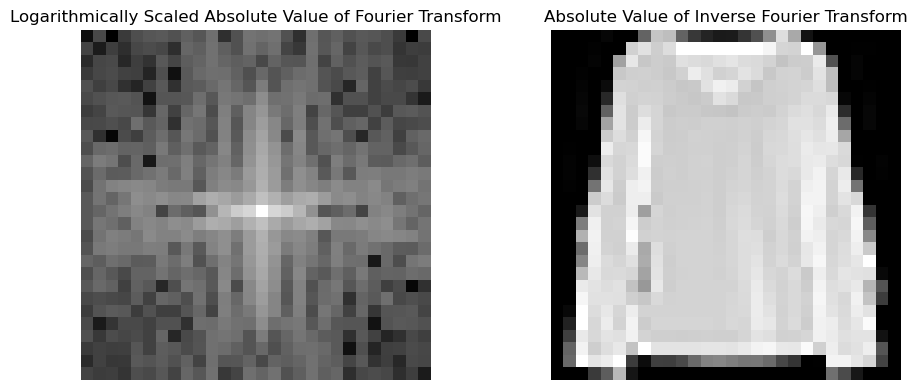

In [8]:
# Load one sample from the test loader
test_sample, test_label = next(iter(train_loader))

# Get the first sample from the batch
test_sample = test_sample[14]
print(test_sample.shape)
test_sample = torch.complex(test_sample[0], test_sample[1])
print(test_sample.real.max(),test_sample.imag.max(), test_sample.real.min(), test_sample.imag.min(),np.abs(test_sample).max(),np.abs(test_sample).min())
# Compute the absolute value and apply logarithmic scaling
abs_fft = torch.abs(test_sample)
log_abs_fft = torch.log(abs_fft + 1e-7)  # Add a small constant to avoid taking log of zero

# Compute the inverse Fourier transform
ifft_sample = torch.fft.ifft2(test_sample)
ifft_abs = torch.abs(ifft_sample)

# Create a new figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

# Plot the logarithmically scaled absolute value of the Fourier transform
ax1.imshow(log_abs_fft.squeeze(), cmap='gray')
ax1.set_title("Logarithmically Scaled Absolute Value of Fourier Transform")
ax1.axis('off')

# Plot the absolute value of the inverse Fourier transform
ax2.imshow(ifft_abs.squeeze(), cmap='gray')
ax2.set_title("Absolute Value of Inverse Fourier Transform")
ax2.axis('off')

plt.tight_layout()
plt.show()

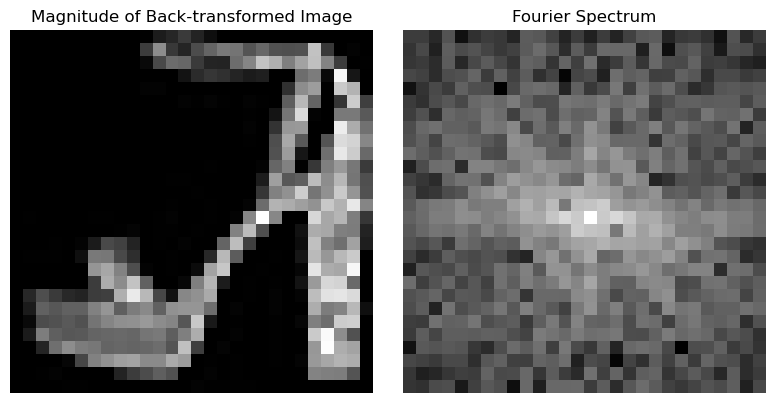

In [9]:
# Assuming you have imported the necessary libraries and defined the layers

# Get one batch from the train_loader
for batch_data, batch_labels in train_loader:
    # Take the first image from the batch
    image = batch_data[0]
    break

# Create instances of the layers
to_complex = TwoChannelsToComplex()
ifft_layer = InverseFourierTransform2D(norm='ortho')
to_two_channels = ComplexToTwoChannels()

# Apply the layers to the image
complex_image = to_complex(image.unsqueeze(0))  # Add batch dimension
back_transformed_complex = ifft_layer(complex_image)
back_transformed_two_channels = to_two_channels(back_transformed_complex)

# Calculate the magnitude of the back-transformed image
magnitude = torch.sqrt(back_transformed_two_channels[:, 0]**2 + back_transformed_two_channels[:, 1]**2)

# Calculate the magnitude of the Fourier spectrum
fourier_spectrum = torch.sqrt(complex_image.real**2 + complex_image.imag**2)

# Display the magnitude image and Fourier spectrum
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 4))

plt.subplot(1, 2, 1)
plt.imshow(magnitude[0].squeeze(), cmap='gray')
plt.title('Magnitude of Back-transformed Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(np.log(fourier_spectrum[0]).squeeze(), cmap='gray')
plt.title('Fourier Spectrum')
plt.axis('off')

plt.tight_layout()
plt.show()

# Test the Fourier Layer

In [11]:
class FourierConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, square_size, input_size):
        super(FourierConv2d, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.square_size = square_size
        self.input_size = input_size
        # Calculate the difference in pixels between the input size and the square size
        self.diff = input_size**2 - square_size**2
        # Define the number of learnable parameters based on the difference
        self.real_weights = nn.Parameter(torch.randn(out_channels, in_channels,self.diff))
        self.imag_weights = nn.Parameter(torch.randn(out_channels, in_channels, self.diff))
        # self.complex_weights = torch.complex(self.real_weights, self.imag_weights)
        # # Create the kernel with the specified structure
        # self.kernel = self.wrap_pixels(self.complex_weights, self.square_size, self.input_size)

    def wrap_pixels(self, pixels_tensor, square_size, input_size):
        """
        This function lets you define trainable filters in the Fourier domain, which are only working on a specific concentric outer square of frequencies.
        Parameters:
        pixels_tensor: This is a tensor of trainable weights. The amount of pixels has to fit the amount of values (defined by the concentric squares) that have to be filled.
        square_size: The side length of the inner square of frequencies that you DON'T want to consider for this filter.
        input_size: The side length of your input.
        Output: A kernel that has an inner square of size square_size filled with ones, and an outer concentric square with trainable parameters.
        """
        # Ensure the input tensors have the correct sizes
        size_diff = input_size - square_size
        square_tensor = torch.ones(1, 1, square_size, square_size)
        wrapped_tensor = torch.zeros(self.out_channels, self.in_channels, input_size, input_size, dtype=pixels_tensor.dtype)
        # Calculate the padding on each side
        pad_top = pad_bottom = pad_left = pad_right = size_diff // 2
        # Adjust the padding if size_diff is odd
        if size_diff % 2 != 0:
            pad_bottom += 1
            pad_right += 1
        # Place the inner square in the center of the wrapped tensor
        wrapped_tensor[:, :, pad_top:input_size-pad_bottom, pad_left:input_size-pad_right] = square_tensor
        # Fill the concentric squares with pixel values
        pixel_index = 0
        for i in range(1, (size_diff + 1) // 2 + 1):
            # Top and bottom rows
            wrapped_tensor[:, :, pad_top-i, pad_left-i:input_size-pad_right+i] = pixels_tensor[:, :, pixel_index:pixel_index+input_size-size_diff+2*i].view(self.out_channels, self.in_channels, -1)
            pixel_index += input_size - size_diff + 2*i
            wrapped_tensor[:, :, input_size-pad_bottom+i-1, pad_left-i:input_size-pad_right+i] = pixels_tensor[:, :, pixel_index:pixel_index+input_size-size_diff+2*i].view(self.out_channels, self.in_channels, -1)
            pixel_index += input_size - size_diff + 2*i
            # Left and right columns (excluding corners)
            wrapped_tensor[:, :, pad_top-i+1:input_size-pad_bottom+i-1, pad_left-i] = pixels_tensor[:, :, pixel_index:pixel_index+input_size-size_diff+2*i-2].view(self.out_channels, self.in_channels, -1)
            pixel_index += input_size - size_diff + 2*i - 2
            wrapped_tensor[:, :, pad_top-i+1:input_size-pad_bottom+i-1, input_size-pad_right+i-1] = pixels_tensor[:, :, pixel_index:pixel_index+input_size-size_diff+2*i-2].view(self.out_channels, self.in_channels, -1)
            pixel_index += input_size - size_diff + 2*i - 2
        return wrapped_tensor
    def forward(self, x):
        x= x.unsqueeze(1)
        complex_weights = torch.complex(self.real_weights, self.imag_weights)
        # Create the kernel with the specified structure
        kernel = self.wrap_pixels(complex_weights, self.square_size, self.input_size).to(device)
        # Perform complex elementwise multiplication
        output = x * kernel
        # Sum over the input channels
        output = output.sum(dim=2)

        return output #, kernel #return kernel if you want to test it the following lines

## Test Kernel

In [12]:
in_channels = 1
out_channels = 16
square_size = 10
input_size = 28

fourier_conv = FourierConv2d(in_channels, out_channels, square_size, input_size)
output, kernel = fourier_conv(torch.complex(torch.rand(1,1,28,28), torch.rand(1,1,28,28)))
print("Kernel shape:", kernel.shape)
plt.imshow(kernel[2,:,:,:].squeeze().detach().real,cmap="gray",vmin=0, vmax=1)
plt.colorbar()

NameError: name 'device' is not defined

In [28]:
# Create an instance of the FourierConv2d layer
fourier_conv = FourierConv2d(in_channels=1, out_channels=16, square_size=24, input_size =28)

# Get a single data sample from the train_loader
data_sample, label = next(iter(train_loader))

# Assuming data_sample has shape (batch_size, 2, height, width)
# Extract the first sample from the batch
sample = data_sample[0]  # Shape: (2, height, width)
# Unsqueeze the sample to add a channel dimension
sample = torch.complex(sample[0], sample[1])
sample = sample.unsqueeze(0).unsqueeze(0)   # Shape: (1, 2, height, width)


# Pass the sample through the FourierConv2d layer
output = fourier_conv(sample)

# Print the output shape
print("Output shape:", output.shape)

AttributeError: 'tuple' object has no attribute 'shape'

torch.Size([64, 28, 28])


AttributeError: 'tuple' object has no attribute 'shape'

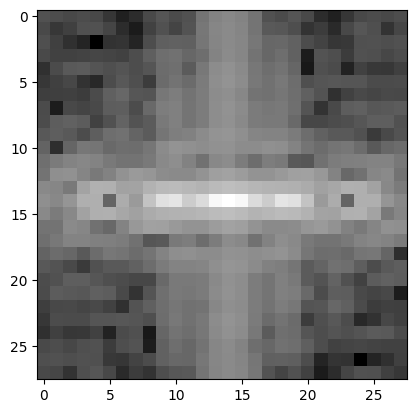

In [29]:
# Create an instance of the FourierConv2d layer
fourier_conv = FourierConv2d(in_channels=1, out_channels=16, square_size=14, input_size =28)

# Get a batch of data from the train_loader
data_batch, labels = next(iter(train_loader))

# Assuming data_batch has shape (batch_size, 2, height, width)
batch_size, _, height, width = data_batch.shape

# Convert the data batch to complex tensors
real_part = data_batch[:, 0, :, :]  # Shape: (batch_size, height, width)
imag_part = data_batch[:, 1, :, :]  # Shape: (batch_size, height, width)
complex_batch = torch.complex(real_part, imag_part)  # Shape: (batch_size, height, width)
complex_batch = torch.fft.fftshift(complex_batch)
plt.imshow(torch.log(torch.abs(complex_batch[0])).squeeze(), cmap="gray")
print(complex_batch.shape)
# Unsqueeze the complex batch to add a channel dimension
complex_batch = complex_batch.unsqueeze(1)  # Shape: (batch_size, 1, height, width)

# Pass the complex batch through the FourierConv2d layer
output = fourier_conv(complex_batch)

# Print the output shape
print("Output shape:", output.shape)

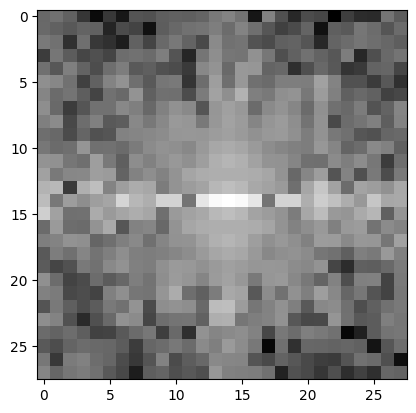

In [16]:
plt.imshow(torch.log(torch.abs((output[0,15,:,:]))).detach().numpy(), cmap="gray")

# Network Structures

In [13]:

class FourierCNN(nn.Module):
    def __init__(self):
        super(FourierCNN, self).__init__()
        self.channeltocomplex = TwoChannelsToComplex()
        self.complextochannel = ComplexToTwoChannels()
        self.ifft = InverseFourierTransform2D(norm='ortho')
        self.conv1 = FourierConv2d(in_channels=1, out_channels=16, square_size=22, input_size =28)
        self.conv2 = FourierConv2d(in_channels=16, out_channels=16, square_size=16, input_size =28) # Decreasing kernel sizes since we Pool
        self.conv3 = FourierConv2d(in_channels=16, out_channels=16, square_size=10, input_size =28)
        self.conv3 = FourierConv2d(in_channels=16, out_channels=16, square_size=4, input_size =28)
        self.conv4 = FourierConv2d(in_channels=16, out_channels=16, square_size=0, input_size =28)
        self.dropout0 = nn.Dropout2d(0.35)
        self.dropout1 = nn.Dropout2d(0.25)
        self.dropout2 = nn.Dropout2d(0.5)
        self.fc1 = nn.Linear(25088, 1024)
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, 128)
        self.fc4 = nn.Linear(128, 10)

    def forward(self, x):
        # print(x.shape)
        x= self.channeltocomplex(x)
        x=x.unsqueeze(1)
        x = self.conv1(x)
        #x = self.maxpool1(x)
        x = ComplexTanh()(x)
        x = self.conv2(x)
        x = ComplexTanh()(x)
        x = self.conv3(x)
        x = ComplexTanh()(x)
        x = self.conv4(x)
        x = ComplexTanh()(x)
        #x = self.dropout1(x)
        x = self.complextochannel(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = nn.functional.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        x = nn.functional.relu(x)
        x = self.dropout0(x)
        x = self.fc3(x)
        x = nn.functional.relu(x)
        x = self.dropout1(x)
        x = self.fc4(x)
        return nn.functional.log_softmax(x, dim=1)

model = FourierCNN()

# Train Loop

In [14]:
from tqdm import tqdm
# 7. Train the network on the Fourier transformed data
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

def train(model, device, train_loader, optimizer, epoch):
    model.train()
    train_loss = 0
    correct = 0
    total = 0
    
    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch}", unit="batch")
    for batch_idx, (data, target) in enumerate(progress_bar):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        _, predicted = output.max(1)
        total += target.size(0)
        correct += predicted.eq(target).sum().item()
        
        progress_bar.set_postfix({"Train Loss": train_loss / (batch_idx + 1), "Train Acc": 100. * correct / total})
    
    train_loss /= len(train_loader)
    train_accuracy = 100. * correct / total
    return train_loss, train_accuracy

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target).item()
            _, predicted = output.max(1)
            total += target.size(0)
            correct += predicted.eq(target).sum().item()
    
    test_loss /= len(test_loader)
    test_accuracy = 100. * correct / total
    return test_loss, test_accuracy


## Start training

In [13]:


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

epochs = 500

for epoch in range(1, epochs + 1):
    train_loss, train_accuracy = train(model, device, train_loader, optimizer, epoch)
    test_loss, test_accuracy = test(model, device, test_loader)
    
    print(f"Epoch {epoch}")
    print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%")
    print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")
    print()

/home/marco/anaconda3/envs/vqvae/lib/python3.8/site-packages/torch/cuda/__init__.py:118: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at /opt/conda/conda-bld/pytorch_1712608851799/work/c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0
Epoch 1:   0%|          | 0/938 [00:00<?, ?batch/s]/home/marco/anaconda3/envs/vqvae/lib/python3.8/site-packages/torch/nn/functional.py:1374: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_

Epoch 1
Train Loss: 0.6979, Train Accuracy: 75.62%
Test Loss: 0.4971, Test Accuracy: 81.82%



Epoch 2: 100%|██████████| 938/938 [04:32<00:00,  3.44batch/s, Train Loss=0.435, Train Acc=84.3]


Epoch 2
Train Loss: 0.4347, Train Accuracy: 84.31%
Test Loss: 0.4627, Test Accuracy: 83.46%



Epoch 3: 100%|██████████| 938/938 [04:35<00:00,  3.40batch/s, Train Loss=0.328, Train Acc=88.1]


Epoch 3
Train Loss: 0.3282, Train Accuracy: 88.14%
Test Loss: 0.4591, Test Accuracy: 84.15%



Epoch 4:   3%|▎         | 29/938 [00:09<04:46,  3.17batch/s, Train Loss=0.206, Train Acc=92.9]


KeyboardInterrupt: 

# Investigate learned filters

In [59]:
def plot_filters(model, layer_name, num_filters, figsize=(8, 4)):
    # Get the convolutional layer by name
    conv_layer = getattr(model, layer_name)
    
    # Extract the real and imaginary weights from the convolutional layer
    real_weights = conv_layer.real_weights.detach().cpu().numpy()
    imag_weights = conv_layer.imag_weights.detach().cpu().numpy()
    print(real_weights.shape)
    # Combine the real and imaginary weights to form the complex weights
    complex_weights = real_weights + 1j * imag_weights
    print(complex_weights.shape)
    # Create the kernel with the specified structure
    kernel = conv_layer.wrap_pixels(torch.from_numpy(complex_weights), conv_layer.square_size, conv_layer.input_size).numpy()
    # Convert complex-valued filters to magnitude
    filters_magnitude = np.abs(kernel)
    print(filters_magnitude.shape)
    # Create a figure and subplots
    fig, axes = plt.subplots(1, num_filters, figsize=figsize)
    
    # Plot each filter
    for i in range(num_filters):
        ax = axes[i]
        im = ax.imshow(filters_magnitude[i, 0], cmap='gray')
        ax.axis('off')

    # Set the title of the figure
    fig.suptitle(f'Filters of {layer_name}')
    cbar = fig.colorbar(im, ax=axes.ravel().tolist(), shrink=0.8)
    cbar.ax.set_ylabel('Magnitude', rotation=90, va='bottom')
    # Adjust the spacing between subplots
    plt.tight_layout()
    # Display the plot
    plt.show()

(16, 16, 784)
(16, 16, 784)
(16, 16, 28, 28)


/tmp/ipykernel_22678/3832523998.py:31: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


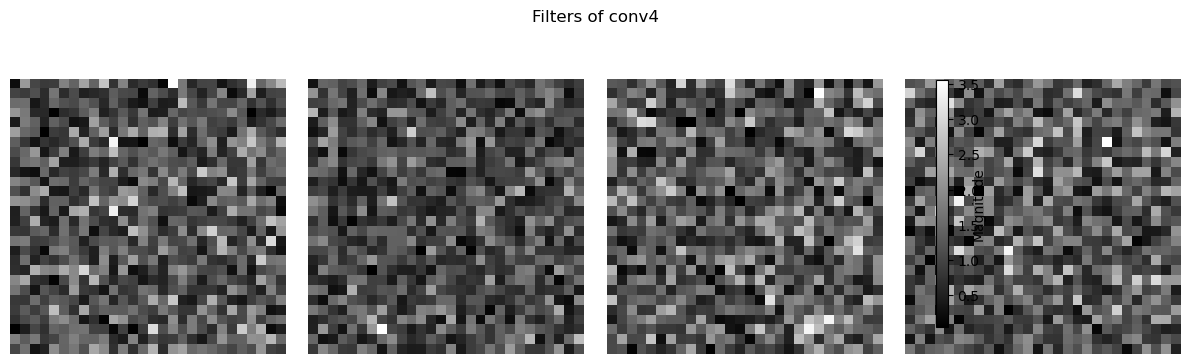

In [60]:
layer_name = 'conv4'  # Specify the name of the convolutional layer
num_filters = 4 # Specify the number of filters to plot

plot_filters(model, layer_name, num_filters, figsize=(12,4))


In [61]:
sample, _ = train_dataset[0]
conv4_layer =  getattr(model, layer_name)
filter_index = 0  # Specify the index of the filter you want to use
real_weights = conv4_layer.real_weights.detach().cpu().numpy()
imag_weights = conv4_layer.imag_weights.detach().cpu().numpy()
complex_weights = real_weights + 1j * imag_weights


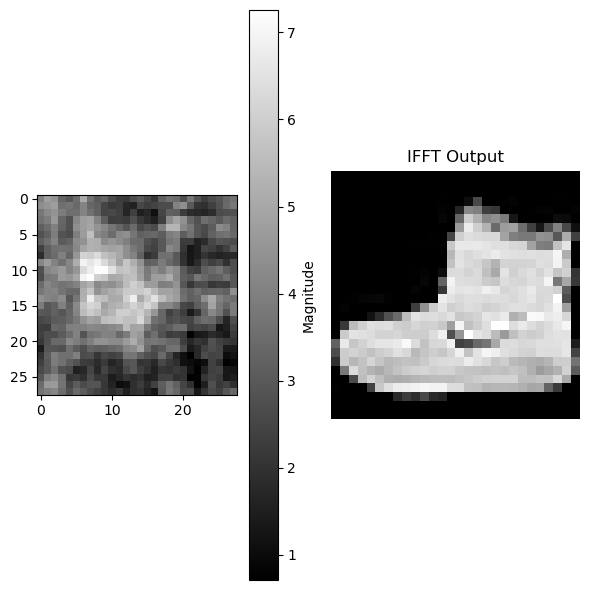

In [81]:
kernel = conv4_layer.wrap_pixels(torch.from_numpy(complex_weights), conv4_layer.square_size, conv4_layer.input_size).numpy()
kernel = torch.tensor(kernel).sum(dim=1)
kernel = np.array(kernel)
kernel = kernel[5]
# Convert the sample to a complex tensor
complex_sample = torch.complex(sample[0], sample[1]).unsqueeze(0).unsqueeze(0)

# Multiply the sample with the filter
output = complex_sample * torch.from_numpy(kernel).unsqueeze(0)
recon = torch.fft.ifft2(complex_sample)
# Apply the inverse Fourier transform
ifft_output = torch.fft.ifftn(output, dim=(-2, -1))

# Convert the result to magnitude
magnitude = torch.abs(ifft_output).squeeze().numpy()

# Visualize the magnitude
plt.figure(figsize=(6, 6))
plt.subplot(1,2,1)
plt.imshow(magnitude, cmap='gray')
plt.colorbar(label='Magnitude')
plt.subplot(1,2,2)
plt.imshow(np.abs(recon).squeeze(), cmap='gray')
plt.title('IFFT Output')
plt.axis('off')
plt.tight_layout()
plt.show()

# Evaluation

## Prediction for a single test example

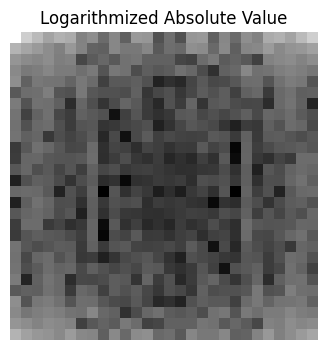

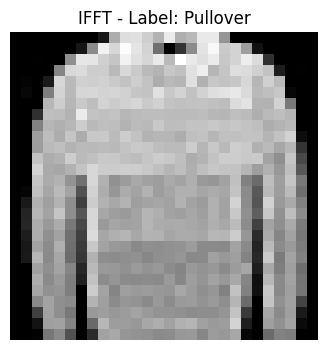

True Label: Pullover
Predicted Label: Pullover


In [56]:
example = 20
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}
# Get a single test example
test_sample, test_label = next(iter(test_loader))
test_sample, test_label = test_sample[example], test_label[example]

# Make a complex number out of real and imaginary channels
complex_sample = torch.complex(test_sample[0], test_sample[1])

# Plot the absolute value logarithmized
abs_sample = torch.abs(complex_sample)
log_abs_sample = torch.log(abs_sample + 1e-7)  # Add a small constant to avoid taking log of zero

plt.figure(figsize=(4, 4))
plt.imshow(log_abs_sample.numpy(), cmap='gray')
plt.title("Logarithmized Absolute Value")
plt.axis('off')
plt.show()

# Apply the inverse Fourier transform and plot the absolute value
ifft_sample = torch.fft.ifft2(complex_sample)
ifft_abs_sample = torch.abs(ifft_sample)

plt.figure(figsize=(4, 4))
plt.imshow(ifft_abs_sample.numpy(), cmap='gray')
plt.title(f"IFFT - Label: {labels_map[test_label.item()]}")
plt.axis('off')
plt.show()

# Put the example into the trained model and predict the class
model.eval()
with torch.no_grad():
    test_sample = test_sample.unsqueeze(0).to(device)
    output = model(test_sample)
    _, predicted = torch.max(output, 1)
    predicted_label = predicted.item()

print(f"True Label: {labels_map[test_label.item()]}")
print(f"Predicted Label: {labels_map[predicted_label]}")

## Confusion Matrix and wrong samples

/home/marco/miniconda3/envs/pytorch-env/lib/python3.10/site-packages/torch/nn/functional.py:1345: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


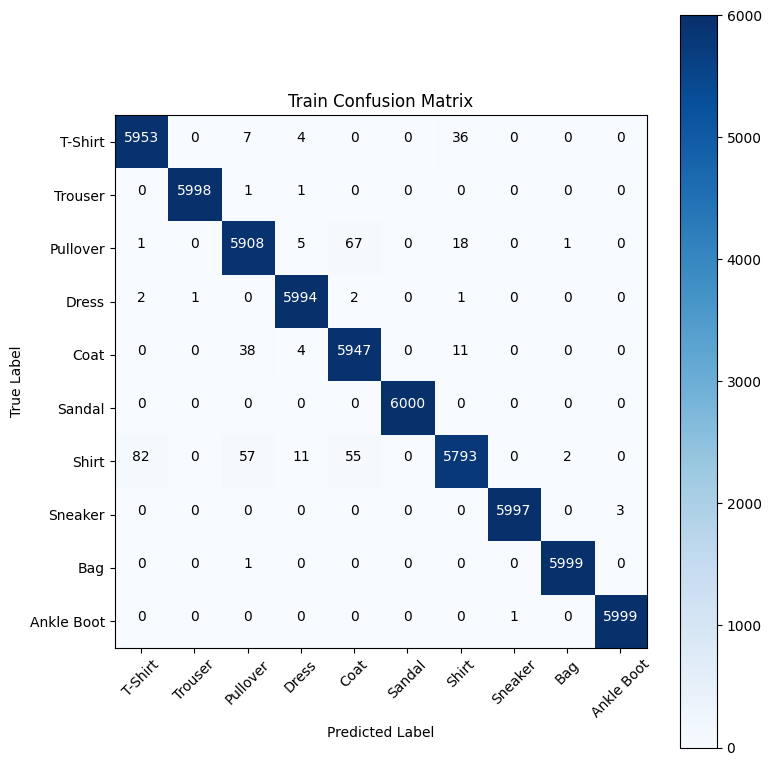

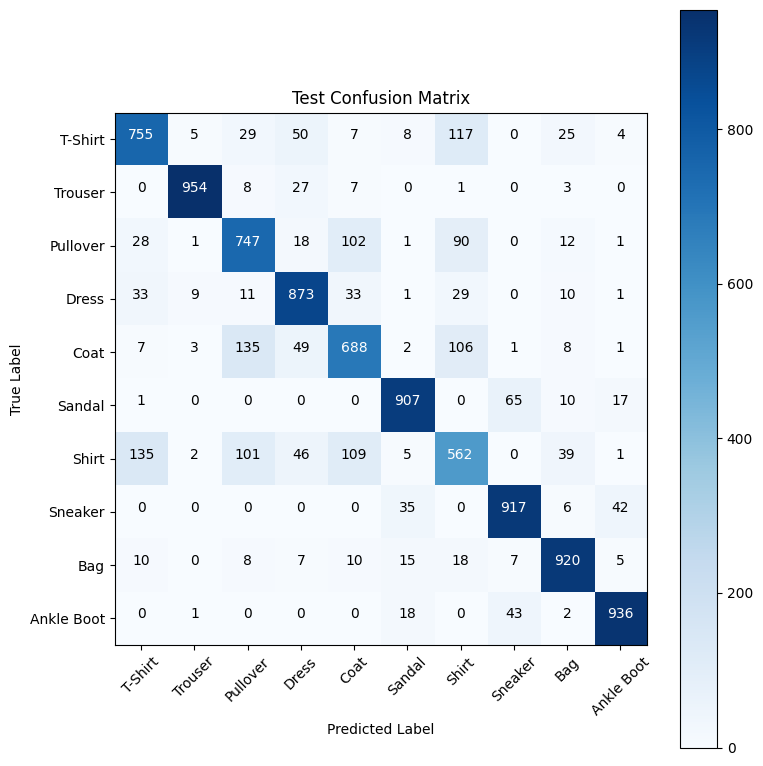

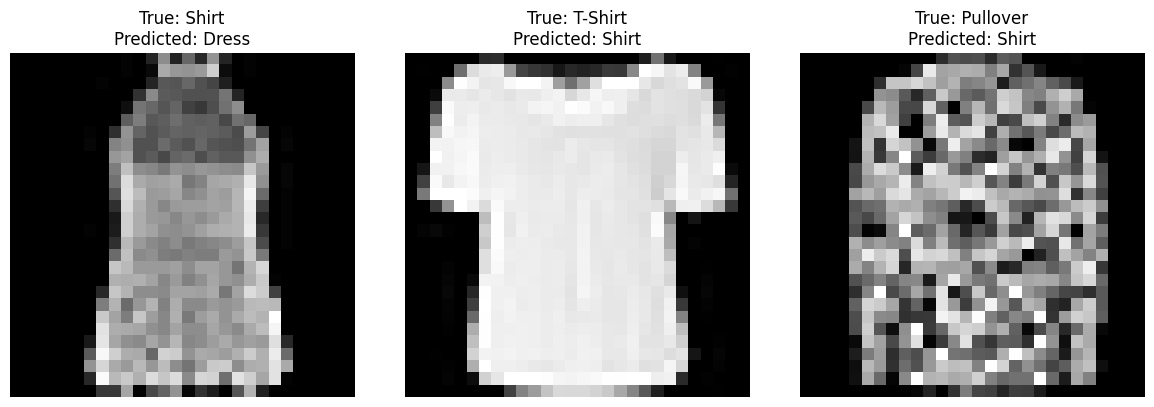

Train Accuracy: 0.9931
Test Accuracy: 0.8259


In [57]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score
import numpy as np
import random

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion Matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    # Add numbers to the confusion matrix
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], 'd'),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.tight_layout()

# Function to get the predictions for a dataset
def get_predictions(model, data_loader, device):
    model.eval()
    predictions = []
    true_labels = []
    with torch.no_grad():
        for data, target in data_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            _, predicted = torch.max(output, 1)
            predictions.extend(predicted.cpu().numpy())
            true_labels.extend(target.cpu().numpy())
    return predictions, true_labels


# Get the predictions for the train and test datasets
train_predictions, train_true_labels = get_predictions(model, train_loader, device)
test_predictions, test_true_labels = get_predictions(model, test_loader, device)


# Plot the confusion matrix for the train dataset with numbers
cm_train = confusion_matrix(train_true_labels, train_predictions)
plt.figure(figsize=(8, 8))
plot_confusion_matrix(cm_train, classes=list(labels_map.values()), normalize=False, title='Train Confusion Matrix')
plt.show()

# Plot the confusion matrix for the test dataset with numbers
cm_test = confusion_matrix(test_true_labels, test_predictions)
plt.figure(figsize=(8, 8))
plot_confusion_matrix(cm_test, classes=list(labels_map.values()), normalize=False, title='Test Confusion Matrix')
plt.show()

# Plot 3 random examples from the wrong predictions
wrong_predictions = [i for i, (p, t) in enumerate(zip(test_predictions, test_true_labels)) if p != t]
random_indices = random.sample(wrong_predictions, 3)

fig, axes = plt.subplots(1, 3, figsize=(12, 4))

for i, idx in enumerate(random_indices):
    img, _ = test_data[idx]
    true_label = test_true_labels[idx]
    predicted_label = test_predictions[idx]
    axes[i].imshow(img.squeeze(), cmap='gray')
    axes[i].set_title(f"True: {labels_map[true_label]}\nPredicted: {labels_map[predicted_label]}")
    axes[i].axis('off')

plt.tight_layout()
plt.show()
# Calculate train and test accuracy
train_accuracy = accuracy_score(train_true_labels, train_predictions)
test_accuracy = accuracy_score(test_true_labels, test_predictions)

# Print train and test accuracy
print(f"Train Accuracy: {train_accuracy:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")